<a href="https://colab.research.google.com/github/shahabas123/Olist-E-commerce-sentiment-analysis/blob/main/NLP_project_Olist_E-commerce%20sentiment%20anlaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %load_ext cuml.accel

In [2]:
!pip install -U scikit-learn imbalanced-learn


In [3]:
!pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score
from deep_translator import GoogleTranslator
from concurrent.futures import ThreadPoolExecutor, as_completed

In [6]:

reviews=pd.read_csv('/content/olist_order_reviews_dataset.csv',nrows=25000)
products=pd.read_csv('/content/olist_products_dataset.csv',nrows=25000)
order_items=pd.read_csv('/content/olist_order_items_dataset.csv',nrows=25000)
category_translation=pd.read_csv('/content/product_category_name_translation.csv',nrows=25000)


merging datasets

 Merge order_items with products on 'product_id'

In [7]:
merged_df=pd.merge(order_items,products,on='product_id',how='left')

 Merge reviews with order_items on 'order_id'

In [8]:
merged_df=pd.merge(merged_df,reviews,on='order_id',how='left')


 Merge category_translation with merged_df on 'product_category_name'

In [9]:
merged_df=pd.merge(merged_df,category_translation,on='product_category_name',how='left')

In [10]:
merged_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,33.0,13.0,33.0,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,16.0,10.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,35.0,40.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25004,38df543e1956e91a0b4ee89c4a49dbf3,1,19c91ef95d509ea33eda93495c4d3481,06a2c3af7b3aee5d69171b0e14f0ee87,2018-05-15 11:55:14,119.99,18.82,beleza_saude,50.0,1257.0,...,25.0,12.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,health_beauty
25005,38e0cb80c67af61efd491a83aed8c8be,1,054515fd15bc1a2029f10de97ffa9120,e9779976487b77c6d4ac45f75ec7afe9,2018-07-30 04:10:23,43.00,18.40,esporte_lazer,50.0,799.0,...,18.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,sports_leisure
25006,38e0e9763bb6c91f55550e6d8555c78b,1,ba9f160a6ae1c23f25d690fd06fe4fd8,ac3508719a1d8f5b7614b798f70af136,2017-11-17 16:46:33,99.90,49.23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25007,38e2829123a2bd1cbe111564824d0abb,1,5bfcd193eb29c1c8332e2d4ca804d54f,522620dcb18a6b31cd7bdf73665113a9,2017-01-30 11:14:58,223.90,15.74,consoles_games,52.0,1236.0,...,17.0,7.0,16.0,9cae90990e603e0c76153b5abf344958,5.0,NaN,"Cara, sem palavras esse serviço, me prometeram...",2017-02-10 00:00:00,2017-02-11 02:42:14,consoles_games


In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25009 entries, 0 to 25008
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       25009 non-null  object 
 1   order_item_id                  25009 non-null  int64  
 2   product_id                     25009 non-null  object 
 3   seller_id                      25009 non-null  object 
 4   shipping_limit_date            25009 non-null  object 
 5   price                          25009 non-null  float64
 6   freight_value                  25009 non-null  float64
 7   product_category_name          18580 non-null  object 
 8   product_name_lenght            18580 non-null  float64
 9   product_description_lenght     18580 non-null  float64
 10  product_photos_qty             18580 non-null  float64
 11  product_weight_g               18821 non-null  float64
 12  product_length_cm              18821 non-null 

In [12]:
merged_df.isna().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
product_category_name,6429
product_name_lenght,6429
product_description_lenght,6429


In [13]:
merged_df.dtypes

,0
order_id,object
order_item_id,int64
product_id,object
seller_id,object
shipping_limit_date,object
price,float64
freight_value,float64
product_category_name,object
product_name_lenght,float64
product_description_lenght,float64


In [14]:
columns=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','review_score']
for column in columns:
  merged_df[column]=merged_df[column].fillna(merged_df[column].mode()[0])

In [15]:
warnings.filterwarnings('ignore')

EDA on DATASET

Top 5 most bought products:

<Axes: xlabel='product_category_name_english', ylabel='count'>

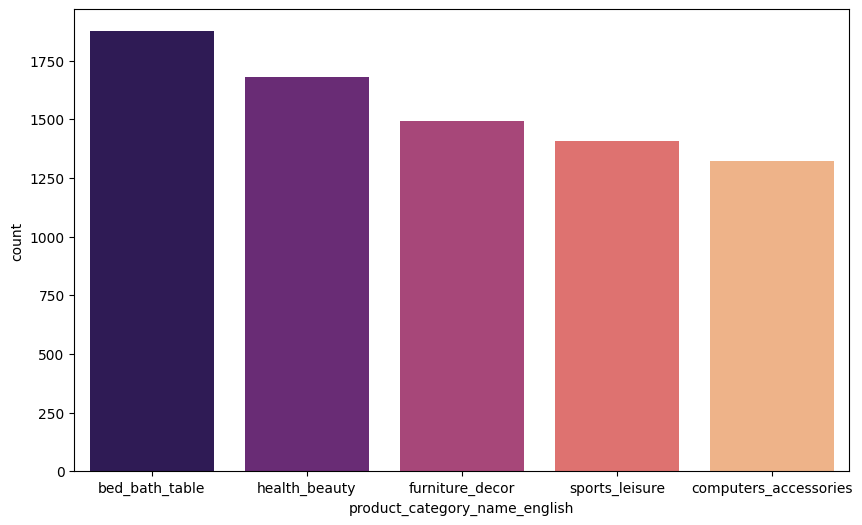

In [16]:
top_5 = merged_df['product_category_name_english'].value_counts().nlargest(5).reset_index()
top_5.columns = ['product_category_name_english', 'count']

plt.figure(figsize=(10,6))
sns.barplot(x='product_category_name_english', y='count', data=top_5, palette='magma')

bed-bath-table is the most bought product

Scatter plot showing if freight_value has influence on review score

<Axes: xlabel='freight_value', ylabel='review_score'>

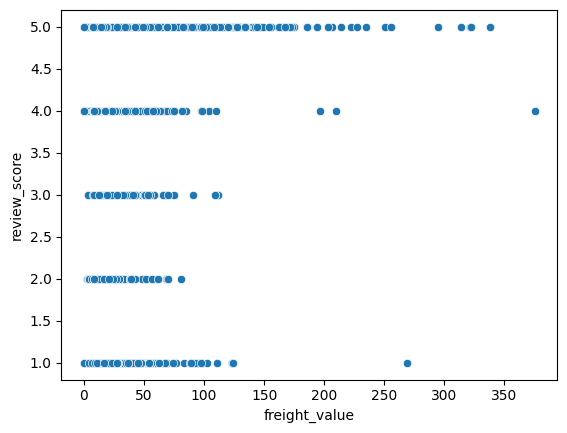

In [17]:
sns.scatterplot(x='freight_value',y='review_score',data=merged_df)

freight_value(delivery of products) has influence on review_score

Scatter plot showing the influence of freight value with price

<Axes: xlabel='price', ylabel='freight_value'>

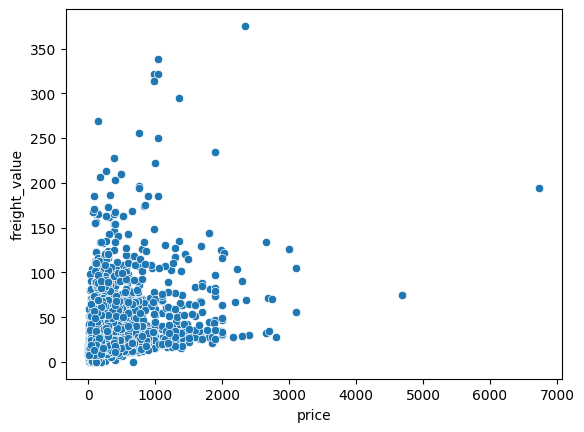

In [18]:
sns.scatterplot(x='price', y='freight_value', data=merged_df)


products priced in range 0-1000 has freight value in the range 0-150

Top 10 product categories based on rating

Text(0, 0.5, 'Average Review Score')

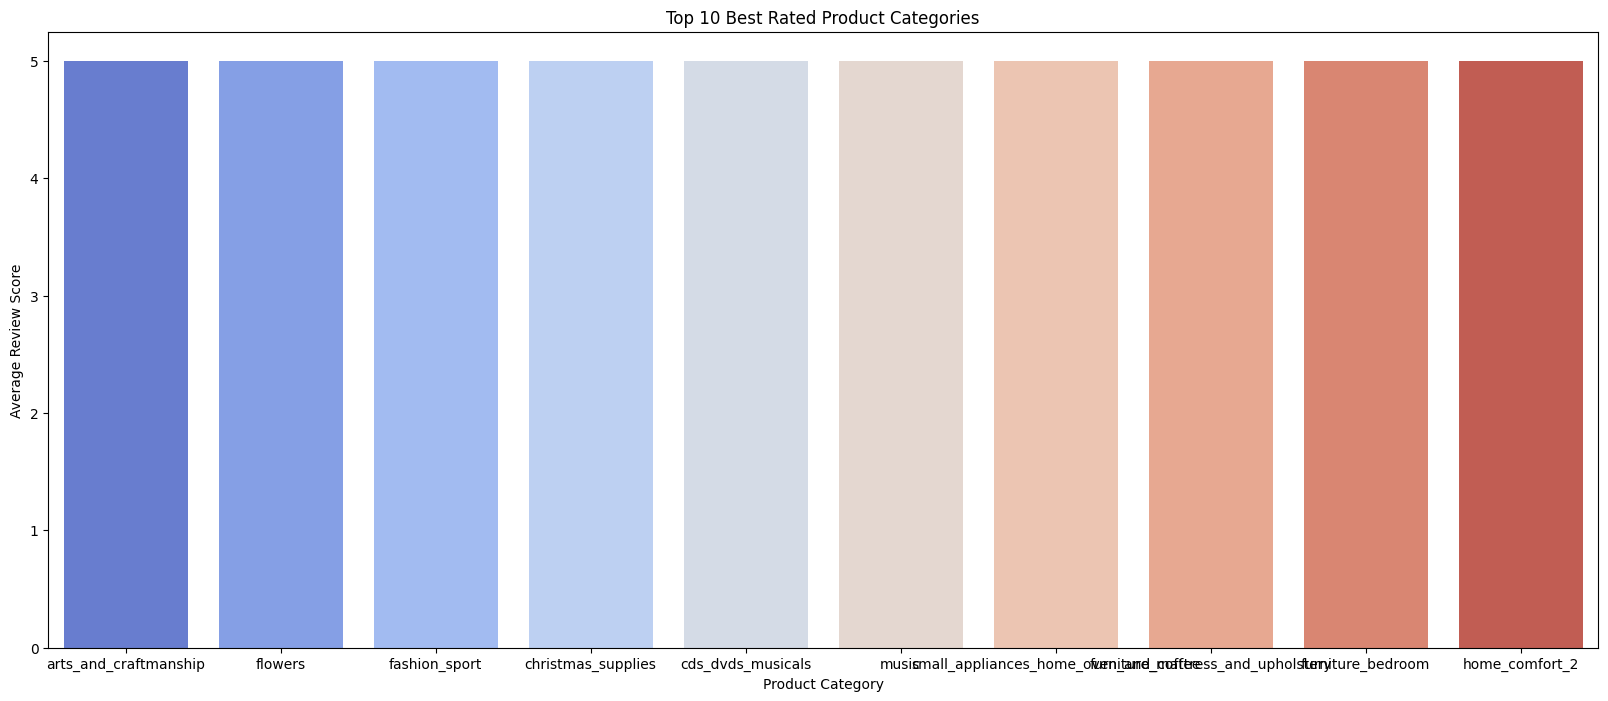

In [19]:
top_rated = merged_df.groupby('product_category_name_english')['review_score'].mean().sort_values(ascending=False).nlargest(10)


plt.figure(figsize=(20, 8))
sns.barplot(x=top_rated.index, y=top_rated.values, palette='coolwarm')


plt.title("Top 10 Best Rated Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Average Review Score")

The above products gave highest review score

Scatter plot that shows the influence of product weight on delivery time

<Axes: xlabel='product_weight_g', ylabel='delivery_time_days'>

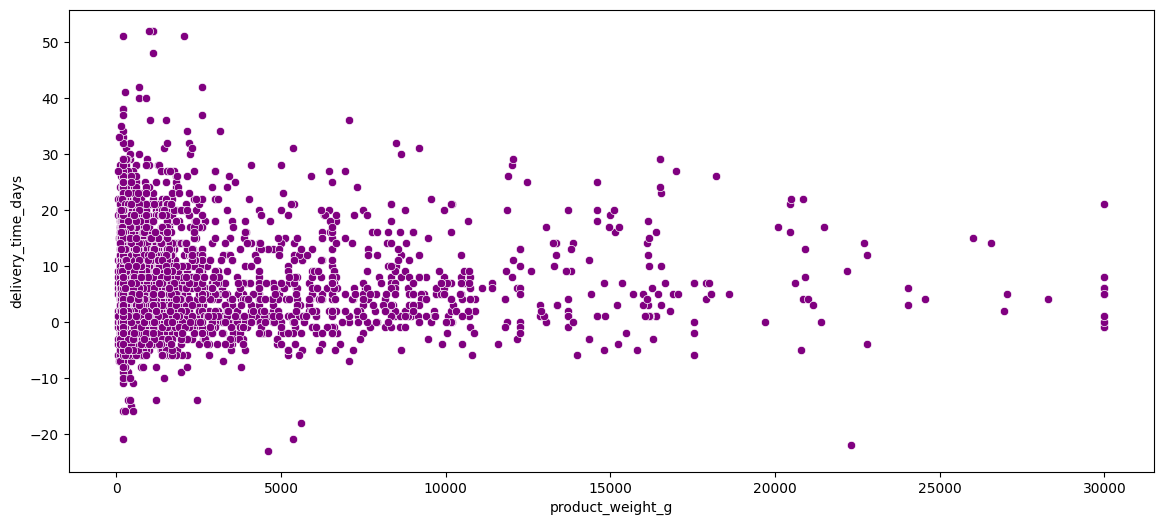

In [20]:

merged_df['shipping_limit_date'] = pd.to_datetime(merged_df['shipping_limit_date'])
merged_df['review_creation_date'] = pd.to_datetime(merged_df['review_creation_date'])

merged_df['delivery_time_days'] = (merged_df['review_creation_date'] - merged_df['shipping_limit_date']).dt.days

plt.figure(figsize=(14, 6))
sns.scatterplot(x='product_weight_g', y='delivery_time_days', data=merged_df, color='purple')

Product weight has no influence on delivery time indicarting delivery team can handle any product

large number of products lie between 5000gms

delivery time is generally between 0 to 30 days for most products.

Boxplot showing how pricing influence review score

<Axes: xlabel='review_score', ylabel='price'>

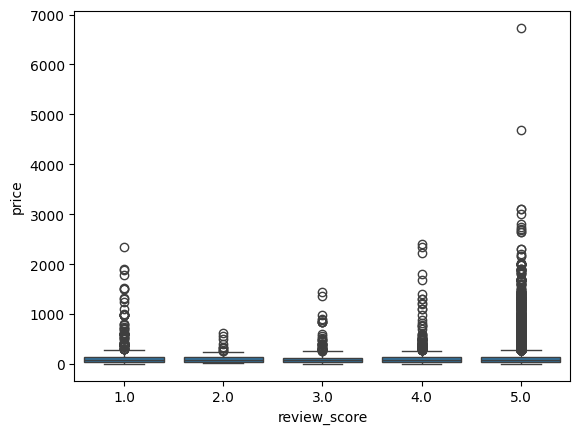

In [21]:
sns.boxplot(x='review_score', y='price', data=merged_df)

Customers who gave review score 5 have bought products with higher price tag




> **SENTIMENT ANALYSIS**





In [22]:
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
24995,f737ad763c9f0816af12ebb6ffcb0b0b,eaac284918a0bae18197faef197f83e0,5,NaN,NaN,2018-07-07 00:00:00,2018-07-09 19:20:57
24996,2ac5020e58dac08a427edbddc0bfadc7,1d38bea3896f01c97d629d249f1c68ff,5,NaN,NaN,2017-08-17 00:00:00,2017-08-18 13:08:03
24997,4f25db0524fd0fae65adffc4e3f3942b,557301323d2ab3151c0e56b06aafd2bc,5,NaN,Satisfatório,2017-12-16 00:00:00,2017-12-19 10:20:08
24998,c9269ed510671c45a87c2a26c650fa44,feb856bfe5b756097c5d2ff2773f5ed3,5,NaN,NaN,2017-09-27 00:00:00,2017-09-30 02:47:14


In [23]:
reviews.drop(['review_id','order_id','review_comment_title','review_creation_date','review_answer_timestamp'],axis=1,inplace=True)

In [24]:
reviews

,review_score,review_comment_message
0,4,NaN
1,5,NaN
2,5,NaN
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...
24995,5,NaN
24996,5,NaN
24997,5,Satisfatório
24998,5,NaN


<Axes: xlabel='review_score', ylabel='count'>

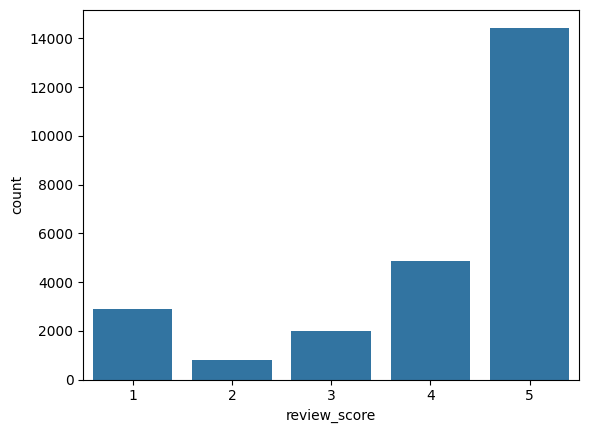

In [25]:

sns.barplot(reviews['review_score'].value_counts())

In [26]:
reviews[reviews['review_comment_message'].isnull()]['review_score'].value_counts()


,count
review_score,
5,9247
4,3278
3,1144
1,649
2,232


from review_score and count, it is observed that Positive review scores like 5 and 4 has most number of missing values. This indicate that positive review count customers didnt leave comments. so they can be labelled as positive review, 3 as neutral review and 2,1 as negative reviews.

In [27]:
def fill_missing_comments(row):
    if pd.isnull(row['review_comment_message']):
        if row['review_score'] == 5 or row['review_score'] == 4:
            return 'Positive Review'
        elif row['review_score'] == 3:
            return 'Neutral Review'
        elif row['review_score'] == 2 or row['review_score'] == 1:
            return 'Negative Review'
    return row['review_comment_message']

reviews['review_comment_message'] = reviews.apply(fill_missing_comments, axis=1)

In [28]:
reviews.isna().sum()

,0
review_score,0
review_comment_message,0


In [29]:
reviews

,review_score,review_comment_message
0,4,Positive Review
1,5,Positive Review
2,5,Positive Review
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...
24995,5,Positive Review
24996,5,Positive Review
24997,5,Satisfatório
24998,5,Positive Review


translate review_comment_message to english

In [30]:

# # Translate only real user-written reviews
# def smart_translate(text):
#     try:
#         # Skip if it's a default synthetic label
#         if text in ['Positive Review', 'Neutral Review', 'Negative Review']:
#             return text
#         return GoogleTranslator(source='pt', target='en').translate(text)
#     except:
#         return text

# # Only translate non-null messages
# to_translate = reviews['review_comment_message'].fillna('').tolist()


# # Use indexed list to track position
# indexed_texts = list(enumerate(to_translate))
# translated_results = [None] * len(indexed_texts)

# with ThreadPoolExecutor(max_workers=10) as executor:
#     futures = {executor.submit(smart_translate, text): i for i, text in indexed_texts}
#     for future in as_completed(futures):
#         idx = futures[future]
#         translated_results[idx] = future.result()

# reviews['translated_message'] = translated_results


In [31]:
# reviews.drop(['review_comment_message'],axis=1,inplace=True)

In [32]:
# reviews.to_csv('translated_reviews.csv', index=False)


In [33]:
translated_reviews=pd.read_csv('/content/translated_reviews.csv')

In [34]:
translated_reviews

,review_score,translated_message
0,4,Positive Review
1,5,Positive Review
2,5,Positive Review
3,5,I received well before the deadline.
4,5,Congratulations Lannister Stores I loved buyin...
...,...,...
24995,5,Positive Review
24996,5,Positive Review
24997,5,Satisfactory
24998,5,Positive Review


In [35]:
translated_reviews.isna().sum()

,0
review_score,0
translated_message,39


In [36]:
def fill_missing_comments(row):
    if pd.isnull(row['translated_message']):
        if row['review_score'] == 5 or row['review_score'] == 4:
            return 'Positive Review'
        elif row['review_score'] == 3:
            return 'Neutral Review'
        elif row['review_score'] == 2 or row['review_score'] == 1:
            return 'Negative Review'
    return row['translated_message']

translated_reviews['translated_message'] = translated_reviews.apply(fill_missing_comments, axis=1)

In [37]:
translated_reviews.isna().sum()

,0
review_score,0
translated_message,0


Remove Special Characters

In [38]:
translated_reviews['translated_message'] = translated_reviews['translated_message'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)
translated_reviews['translated_message']


,translated_message
0,Positive Review
1,Positive Review
2,Positive Review
3,I received well before the deadline
4,Congratulations Lannister Stores I loved buyin...
...,...
24995,Positive Review
24996,Positive Review
24997,Satisfactory
24998,Positive Review


convert to root words

In [39]:
nltk.download('punkt_tab')
ps=PorterStemmer()
translated_reviews['translated_message']=translated_reviews['translated_message'].apply(lambda row:[ps.stem(token.lower()) for token in nltk.word_tokenize(row)]).apply(lambda token:" ".join(token))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [40]:
translated_reviews['translated_message']

,translated_message
0,posit review
1,posit review
2,posit review
3,i receiv well befor the deadlin
4,congratul lannist store i love buy the interne...
...,...
24995,posit review
24996,posit review
24997,satisfactori
24998,posit review


Remove stopwords

In [41]:

nltk.download('stopwords')
sw=stopwords.words('english')
print(sw)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
translated_reviews['translated_message']=translated_reviews['translated_message'].apply(lambda row:[token for token in nltk.word_tokenize(row) if token not in sw]).apply(lambda token:" ".join(token))

vectorization

In [43]:

vec=TfidfVectorizer(max_features=3000)
data_vec=vec.fit_transform(translated_reviews['translated_message'])
print(data_vec)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 99111 stored elements and shape (25000, 3000)>
  Coords	Values
  (0, 2278)	0.7385369554964567
  (0, 2461)	0.674212997031372
  (1, 2278)	0.7385369554964567
  (1, 2461)	0.674212997031372
  (2, 2278)	0.7385369554964567
  (2, 2461)	0.674212997031372
  (3, 2396)	0.4676624040704164
  (3, 2928)	0.5700300114655505
  (3, 283)	0.4728459908311181
  (3, 602)	0.4824669219776639
  (4, 505)	0.46792219180468975
  (4, 1676)	0.23475460181717475
  (4, 2683)	0.19690902974728147
  (4, 1787)	0.21099553782786873
  (4, 356)	0.21036090990229064
  (4, 1556)	0.32143708215940653
  (4, 2494)	0.32143708215940653
  (4, 2285)	0.3086528307206377
  (4, 1354)	0.31901970281997455
  (4, 858)	0.44126111053959216
  (5, 2461)	0.33457470446198184
  (5, 2083)	0.9423692307870508
  (6, 2278)	0.7385369554964567
  (6, 2461)	0.674212997031372
  (7, 2278)	0.7385369554964567
  :	:
  (24989, 517)	0.2861968454941027
  (24989, 209)	0.4289122842734162
  (24990, 2278)	0.7385369

In [44]:
X=data_vec.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
y=reviews['review_score']
y

,review_score
0,4
1,5
2,5
3,5
4,5
...,...
24995,5
24996,5
24997,5
24998,5


In [46]:
import gc
gc.collect()

139

In [58]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [59]:
# knn=KNeighborsClassifier(n_neighbors=5)
sv=SVC()
rf=RandomForestClassifier(random_state=1)
ab=AdaBoostClassifier(random_state=1)
nb=MultinomialNB()


models=[sv,rf,ab,nb]
for model in models:
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  print("***************",model,"*****************")
  print(classification_report(y_test,y_pred))

*************** SVC() *****************
              precision    recall  f1-score   support

           1       0.63      0.90      0.74       909
           2       0.00      0.00      0.00       227
           3       0.94      0.58      0.72       629
           4       0.35      0.03      0.05      1389
           5       0.74      0.98      0.84      4346

    accuracy                           0.73      7500
   macro avg       0.53      0.50      0.47      7500
weighted avg       0.65      0.73      0.65      7500

*************** RandomForestClassifier(random_state=1) *****************
              precision    recall  f1-score   support

           1       0.63      0.87      0.73       909
           2       0.14      0.01      0.02       227
           3       0.94      0.57      0.71       629
           4       0.27      0.02      0.04      1389
           5       0.74      0.97      0.84      4346

    accuracy                           0.72      7500
   macro avg      

In [60]:
os=SMOTE()
X_os,y_os=os.fit_resample(X,y)

In [61]:
X_train_os,X_test_os,y_train_os,y_test_os=train_test_split(X_os,y_os,test_size=0.3,random_state=1)

In [62]:
acc=[]
# knn_os=KNeighborsClassifier(n_neighbors=5)
sv_os=SVC()
rf_os=RandomForestClassifier(random_state=1)
ab_os=AdaBoostClassifier(random_state=1)
nb_os=MultinomialNB()


models=[sv_os,rf_os,ab_os,nb_os]
for model in models:
  model.fit(X_train_os,y_train_os)
  y_pred_os=model.predict(X_test_os)
  print("***************",model,"*****************")
  print(classification_report(y_test_os,y_pred_os))
  acc.append(accuracy_score(y_test_os,y_pred_os))

*************** SVC() *****************
              precision    recall  f1-score   support

           1       0.82      0.76      0.79      4240
           2       0.80      0.98      0.88      4302
           3       0.95      0.90      0.92      4350
           4       0.55      0.83      0.66      4411
           5       0.76      0.30      0.43      4365

    accuracy                           0.75     21668
   macro avg       0.78      0.75      0.74     21668
weighted avg       0.78      0.75      0.74     21668

*************** RandomForestClassifier(random_state=1) *****************
              precision    recall  f1-score   support

           1       0.88      0.76      0.82      4240
           2       0.81      0.99      0.89      4302
           3       0.96      0.95      0.95      4350
           4       0.57      0.88      0.69      4411
           5       0.76      0.29      0.42      4365

    accuracy                           0.77     21668
   macro avg      

In [68]:
y_new=rf.predict(vec.transform(['']))
if y_new==5 or y_new==4:
  print("Positive review")
elif y_new==3:
  print("Neutral review")
else:
  print("Negative review")

Positive review


In [70]:
import pickle
pickle.dump(rf_os, open('rf_model.pkl', 'wb'))
pickle.dump(vec, open('tfidf_vectorizer.pkl', 'wb'))